In [1]:
import pyspark.sql.functions as F

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_categorize_twitteres1")

23/03/10 10:46:11 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
df.count()

3141909

In [6]:
df_sample = df.limit(10).cache()

In [7]:
input_fmt = "EEE MMM dd HH:mm:ss ZZZZ yyyy"
output_date_fmt = "MM/dd/yyyy"
output_time_fmt = "HH:mm:ss"

In [8]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [9]:
# Apply the transformations to extract the date and time components
result = df_sample.select(
    F.to_utc_timestamp(F.unix_timestamp(F.col("created_at"), input_fmt).cast("timestamp"), "UTC").alias("timestamp"),
    F.date_format(F.to_utc_timestamp(F.unix_timestamp(F.col("created_at"), input_fmt).cast("timestamp"), "UTC"), output_date_fmt).alias("date"),
    F.date_format(F.to_utc_timestamp(F.unix_timestamp(F.col("created_at"), input_fmt).cast("timestamp"), "UTC"), output_time_fmt).alias("time"),
    'created_at'
)

result.limit(1)

timestamp,date,time,created_at
2022-05-23 21:32:03,05/23/2022,21:32:03,Mon May 23 21:32:...


In [10]:
df = df.withColumn('created_at_timestamp', F.to_utc_timestamp(F.unix_timestamp(F.col("created_at"), input_fmt).cast("timestamp"), "UTC"))

In [11]:
df.select('created_at','created_at_timestamp').limit(10).toPandas()

,created_at,created_at_timestamp
0,Tue Aug 02 15:20:20 +0000 2022,2022-08-02 15:20:20
1,Tue Aug 02 15:20:23 +0000 2022,2022-08-02 15:20:23
2,Tue Aug 02 15:20:27 +0000 2022,2022-08-02 15:20:27
3,Tue Aug 02 15:20:37 +0000 2022,2022-08-02 15:20:37
4,Tue Aug 02 15:20:44 +0000 2022,2022-08-02 15:20:44
5,Tue Aug 02 15:20:49 +0000 2022,2022-08-02 15:20:49
6,Tue Aug 02 15:20:50 +0000 2022,2022-08-02 15:20:50
7,Tue Aug 02 15:20:52 +0000 2022,2022-08-02 15:20:52
8,Tue Aug 02 15:20:53 +0000 2022,2022-08-02 15:20:53
9,Tue Aug 02 15:21:10 +0000 2022,2022-08-02 15:21:10


**Location Analysis**

In [12]:
df.select(['user_name', 'user_location']).limit(10).toPandas()

,user_name,user_location
0,StrongerTMU,TorontoMetU - Toronto
1,Pravin Jeya,"Sutton, London"
2,Wakefield Strong,"Raleigh, NC"
3,Krishna Suma Sreedharan,Cochin
4,FTW,🍊 County
5,Saffron_Lion 🇮🇳I_am_Modi🇮🇳,"Kolkata, India"
6,sam.,"Baltimore, MD"
7,Rajshri Mahtani,"Mumbai, India"
8,Teshley Solutions,"New Jersey, USA"
9,mizuki,dead end.


In [13]:
df_user_location = df.groupBy('user_name').agg(F.first('user_location').alias('location'))

In [14]:
df_user_location.count()

1429862

In [15]:
df_user_location.limit(10)

user_name,location
ANTHONIO DE' GR8,"Lagos, Nigeria"
Abode al airqi,Morocco
Engr Iftikhar kamal,Malaysia
Nauman Awan,"Karachi, Pakistan"
TEAM SLAMOLA,Simco mountain : ...
William White,"""The Meadows"""
bharatan patil,"Jalgaon, India"
!,Paid rts? DM
! AM,"Los Angeles, CA"
! Scientist!,"Harare, Zimbabwe"


In [16]:
df_count = df_user_location.groupBy('location').agg(F.count('user_name').alias('location_wise_count_of_users')).orderBy('location_wise_count_of_users', ascending=False)

In [17]:
df_count.count()

427699

In [18]:
df_count.limit(5)

location,location_wise_count_of_users
"Lagos, Nigeria",19229
United States,18239
Nigeria,15845
India,13090
"Nairobi, Kenya",7847


In [19]:
df_count.printSchema()

root
 |-- location: string (nullable = true)
 |-- location_wise_count_of_users: long (nullable = false)



In [20]:
df_count.limit(200).agg(F.sum('location_wise_count_of_users')).show()

+---------------------------------+
|sum(location_wise_count_of_users)|
+---------------------------------+
|                           425556|
+---------------------------------+



In [21]:
pd_df_count = df_count.limit(200).toPandas()

In [21]:
# %pip install geocoder

In [22]:
# %%time
# import geocoder
# import pandas as pd
# import time

# # define a function to geocode locations in batches

# def geocode_batch(locations):
#     # geocode the locations in batches
#     batch_size = 100
#     results = []
#     for i in range(0, len(locations), batch_size):
#         batch = locations[i:i+batch_size]
#         batch_str = ','.join([''] if x is None else x for x in batch)
#         # geocode the batch
#         g = geocoder.osm(batch_str, timeout=10)
#         if g.ok:
#             results.extend(g)
#         # sleep to avoid hitting rate limits
#         time.sleep(1)
#     return results

# # define a function to get country from location
# def get_country(location, cache):
#     # check if the country is in the cache
#     if location in cache:
#         return cache[location]
    
#     # otherwise, geocode the location
#     g = geocoder.osm(location, timeout=10)
#     if g.ok:
#         # cache the result
#         cache[location] = g.country
#         return g.country
#     else:
#         return None

# # initialize a cache
# cache = {}

# # extract the locations from the Pandas DataFrame as a list
# locations = pd_df_count['user_location'].tolist()

# # geocode the locations in batches
# results = geocode_batch(locations)

# # map the results to a dictionary
# location_dict = {}
# for result in results:
#     if result is not None:
#         location_dict[result['query']] = result['country']

# # add a new 'country' column to the dataframe
# pd_df_count['country'] = pd_df_count['user_location'].apply(lambda location: get_country(location, cache))

In [22]:
# %pip install geopy

In [23]:
import pandas as pd
from geopy.geocoders import Nominatim
import time

# define a function to geocode locations in batches

def geocode_batch(locations):
    # geocode the locations in batches
    batch_size = 50
    results = []
    for i in range(0, len(locations), batch_size):
        batch = locations[i:i+batch_size]
        # geocode the batch
        geolocator = Nominatim(user_agent="BPP-Project")
        try:
            batch_results = geolocator.geocode(batch, addressdetails=True, language='en', exactly_one=False)
            if batch_results is not None:
                results.extend(batch_results)
        except Exception as e:
            print(e)
        # sleep to avoid hitting rate limits
        time.sleep(1)
    return results

# define a function to get country from location
def get_country(location, cache):
    # check if the country is in the cache
    if location in cache:
        return cache[location]
    
    # otherwise, geocode the location
    geolocator = Nominatim(user_agent="BPP-Project")
    location_data = geolocator.geocode(location, addressdetails=True, language='en')
    if location_data is not None:
        country = location_data.raw['address'].get('country', None)
        # cache the result
        cache[location] = country
        return country
    else:
        return None

# initialize a cache
cache = {}

# extract the locations from the Pandas DataFrame as a list
locations = pd_df_count['location'].tolist()

# geocode the locations in batches
results = geocode_batch(locations)

# map the results to a dictionary
location_dict = {}
for result in results:
    if result is not None:
        location_dict[result.address] = result.raw['address'].get('country', None)

# add a new 'country' column to the dataframe
pd_df_count.drop('location_wise_count_of_users',axis=1, inplace=True)
pd_df_count['country'] = pd_df_count['location'].apply(lambda location: get_country(location, cache))

# save the updated data to CSV file
# pd_df_count.to_csv('output_file.csv', index=False)

In [24]:
pd_df_count.iloc[10:30]

,location,country
10,"Chicago, IL",United States
11,"Washington, DC",United States
12,"Texas, USA",United States
13,"Atlanta, GA",United States
14,she/her,Taiwan
15,"New Delhi, India",India
16,Canada,Canada
17,"Florida, USA",United States
18,"Abuja, Nigeria",Nigeria
19,"Kampala, Uganda",Uganda


In [25]:
pd_df_count.rename(columns={'location': 'user_location'}, inplace=True)

In [26]:
pd_df_count.head()

,user_location,country
0,"Lagos, Nigeria",Nigeria
1,United States,United States
2,Nigeria,Nigeria
3,India,India
4,"Nairobi, Kenya",Kenya


In [27]:
df_locations = spark.createDataFrame(pd_df_count)

In [28]:
df_locations.limit(10)

user_location,country
"Lagos, Nigeria",Nigeria
United States,United States
Nigeria,Nigeria
India,India
"Nairobi, Kenya",Kenya
"London, England",United Kingdom
"Los Angeles, CA",United States
"California, USA",United States
USA,United States
"Houston, TX",United States


In [29]:
df = df.join(df_locations, 'user_location', 'left')

In [30]:
df.limit(10).toPandas()

,user_location,id,created_at,user_name,user_description,verified_status,followers_count,geo_enabled,user_id_str,user_id,tweet_text,text,retweet_count,retweeted_status,geo,stripped,organization,created_at_timestamp,country
0,WI,1562568628230582274,Wed Aug 24 22:32:46 +0000 2022,WICountryGigi,BLUE in 2022\nJustice-then Unity (NO white su...,False,1501,False,1190039531174744064,1190039531174744064,let’s talk about who has student debt in ameri...,RT @ewarren: Let’s talk about who has student ...,354,"(None, Wed Aug 24 22:05:10 +0000 2022, None, (...",None,let’s talk about who has student debt in ameri...,Others,2022-08-24 22:32:46,None
1,"Burlington, WA",1562912078717140996,Thu Aug 25 21:17:31 +0000 2022,Jessica Oliver,"reader, librarian, teacher, hiker, walker, gar...",False,188,False,823302761924001792,823302761924001792,when students look at me with a puppy dog face...,RT @FixingEducation: When students look at me ...,6,"(None, Thu Aug 25 17:28:56 +0000 2022, None, (...",None,when students look at me with a puppy dog face...,Others,2022-08-25 21:17:31,None
2,"Chesterfield, VA",1547615047467163648,Thu Jul 14 16:12:35 +0000 2022,CCPS United,"Divided we beg, United we bargain — For better...",False,35,False,1543977142421073922,1543977142421073922,i met a school counselor who was responsible f...,RT @NicholasFerroni: I met a school counselor ...,246,"(None, Mon Jul 11 22:34:36 +0000 2022, None, (...",None,i met a school counselor who was responsible f...,Others,2022-07-14 16:12:35,None
3,"St Petersburg, FL",1519726078369189888,Thu Apr 28 17:11:46 +0000 2022,JonnyLightYear,Tech. Freedom. Decentralization. The future is...,False,13,False,1518735711196823553,1518735711196823553,florida public schools were open for all stude...,RT @ChristinaPushaw: Florida public schools we...,195,"(None, Thu Apr 28 15:47:12 +0000 2022, [0, 140...",None,florida public schools were open for all stude...,Others,2022-04-28 17:11:46,None
4,Bangalore,1570491915866607617,Thu Sep 15 19:17:05 +0000 2022,geeta krishnamurthy,None,False,8,False,2784361448,2784361448,#engineering\n#engineeringlife\n#engineersday\...,RT @SarcasamHit: #Engineering\n#engineeringlif...,119,"(None, Thu Sep 15 03:24:26 +0000 2022, [0, 72]...",None,engineering\nengineeringlife\nengineersday\n\n...,Others,2022-09-15 19:17:05,India
5,"lagos, Nigeria",1618187560832098305,Wed Jan 25 10:02:33 +0000 2023,Touri The Craftsman,Art Enthusiast//\nCraftsman//\nCreator of #the...,False,316,True,415704001,415704001,no university should set exam timetable during...,RT @VictorIsrael_: No university should set ex...,2208,"(None, Tue Jan 24 19:40:14 +0000 2023, [0, 140...",None,no university should set exam timetable during...,Others,2023-01-25 10:02:33,None
6,iCloud,1523725682714755073,Mon May 09 18:04:46 +0000 2022,اليكس,Elephant herder|Zeitgeist|Seeking Shangri-La |...,False,4834,False,64760588,64760588,graduated from howard university school of law...,RT @ada_x0: graduated from Howard University S...,519,"(None, Sun May 08 20:51:44 +0000 2022, [0, 110...",None,graduated from howard university school of law...,Others,2022-05-09 18:04:46,None
7,Nor CA,1554924673288196097,Wed Aug 03 20:18:25 +0000 2022,Allison 🌻,"Live Music, Politics, Comedy & Tech. Californi...",False,12623,False,557432619,557432619,how to say #votersuppression w/out saying it? ...,RT @tizzywoman: How to say #VoterSuppression w...,9,"(None, Wed Aug 03 19:16:47 +0000 2022, [0, 140...",None,how to say votersuppression w/out saying it? 😤...,Influencers,2022-08-03 20:18:25,None
8,"In a galaxy far, far away...",1550720336290783232,Sat Jul 23 05:51:53 +0000 2022,Abby,"23 | Just be yourself, boo. Vive y ama, ama y ...",False,99,False,2429707362,2429707362,crying at the visual of elementary student tae...,RT @artemiskv: crying at the visual of element...,40,"(None, Fri Jul 22 14:10:13 +0000 2022, [0, 140...",None,crying at the visual of elementary student tae...,Others,2022-07-23 05:51:53,None
9,Hee BaeJ,1600080928290013185,Tue Dec 06 10:53:16

In [ ]:
df.write.mode('overwrite').parquet('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_categorize_twitteres//with_location1')

In [51]:
df_raw = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/harshamuthukuru/df_categorize_twitteres//with_location1')

In [52]:
df_raw.count()

3141909

In [53]:
df_filtered = df_raw.filter('country is not null')

In [54]:
df_filtered.count()

1005604

In [55]:
df_filtered.limit(5)

user_location,id,created_at,user_name,user_description,verified_status,followers_count,geo_enabled,user_id_str,user_id,tweet_text,text,retweet_count,retweeted_status,geo,stripped,organization,created_at_timestamp,country
Bangalore,1617858132071567362,Tue Jan 24 12:13:...,🇺🇦 🇵🇸 🇦🇫 Sh...,° Architect - Aca...,false,127,true,230918668,230918668,"bbc documentary ""...",RT @Advaidism: BB...,220,"{null, Tue Jan 24...",null,bbc documentary i...,Others,2023-01-24 12:13:31,India
Bangalore,1605577052194713600,Wed Dec 21 14:52:...,Lalitha,null,false,248,false,328966848,328966848,history of kashmi...,RT @sunandavashis...,756,"{null, Tue Dec 20...",null,history of kashmi...,Others,2022-12-21 14:52:54,India
Bangalore,1557759613394567168,Thu Aug 11 16:03:...,himanshu,Current affairs. ...,false,502,false,74416825,74416825,kolkata's st xavi...,RT @AskAnshul: Ko...,492,"{null, Thu Aug 11...",null,kolkatas st xavie...,Others,2022-08-11 16:03:28,India
Bangalore,1543309659137748992,Sat Jul 02 19:04:...,Capstone Investments,not a penny more ...,false,155,true,617236586,617236586,"got puc, ncert te...",RT @WFRising: Got...,4,"{null, Tue Jun 28...",null,got puc ncert tex...,Others,2022-07-02 19:04:30,India
Bangalore,1596922016400953346,Sun Nov 27 17:40:...,Wisdom,null,false,34,true,910189952465436672,910189952465436672,3 students passed...,RT @AskAnshul: 3 ...,1463,"{null, Sun Nov 27...",null,3 students passed...,Others,2022-11-27 17:40:52,India


In [56]:
pd_df_1 = df_filtered.groupBy('country').agg(F.count('id').alias('Count')).toPandas()

In [57]:
pd_df_1.rename(columns={'country':'Country'}, inplace=True)

In [58]:
pd_df_1.shape

(27, 2)

In [59]:
pd_df_1.sort_values('Count', ascending=False, inplace=True)

In [60]:
pd_df_1.reset_index(inplace=True, drop=True)

In [61]:
pd_df_1['Country'].replace('United States', 'United States of America', inplace=True)

In [62]:
pd_df_1

,Country,Count
0,United States of America,476195
1,Nigeria,144475
2,India,106815
3,United Kingdom,66961
4,Canada,40131
5,Pakistan,27571
6,Kenya,26979
7,Ghana,20609
8,South Africa,17599
9,Uganda,14495


**Country wise users**

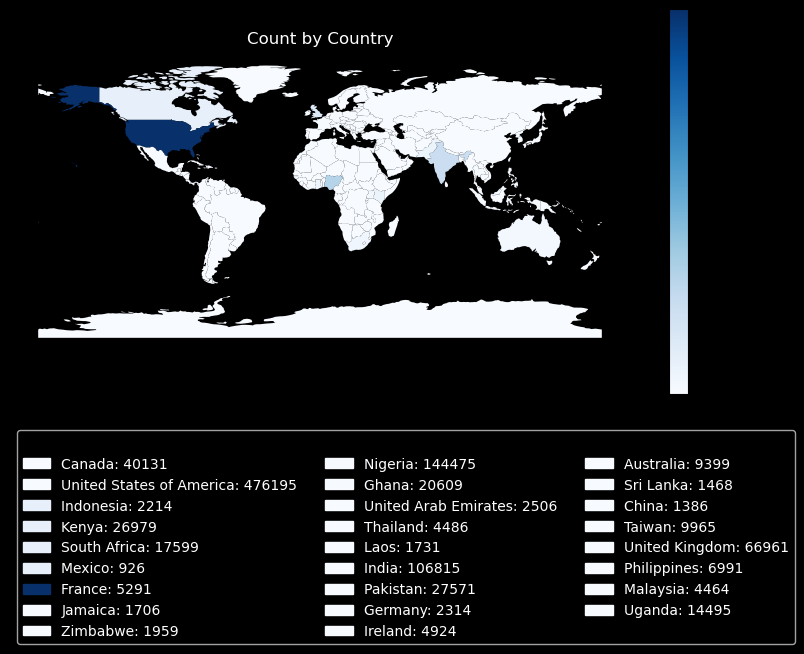

In [63]:
import geopandas as gpd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Load the world map data into a GeoDataFrame
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Join the data with the world map GeoDataFrame
joined_df = world_map.merge(pd_df_1, how='left', left_on='name', right_on='Country')
joined_df['Count'] = joined_df['Count'].fillna(0)

# Create the plot using GeoPandas
# Set the background color of the plot to black
fig = plt.figure(figsize=(10, 5), facecolor='k')

# Create the plot using GeoPandas
ax = joined_df.plot(column='Count', cmap='Blues', legend=True, ax=fig.gca(), vmin=0)

# Set the plot title and remove the axes
ax.set_title('Count by Country', color='w')
ax.set_axis_off()

# Customize the legend
handles = []
labels = []
for i in range(len(joined_df)):
    if joined_df['Count'][i] > 0:
        handle = plt.Rectangle((0, 0), 1, 1, color=ax.collections[0]._facecolors[i])
        label = f"{joined_df['name'][i]}: {int(joined_df['Count'][i])}"
        handles.append(handle)
        labels.append(label)
ax.legend(handles, labels, title='Count', loc='lower left', bbox_to_anchor=(0, -1), ncol=3, facecolor='k')

# Set the color of the legend text to white
for text in ax.get_legend().get_texts():
    text.set_color('w')

# Display the plot
plt.show()


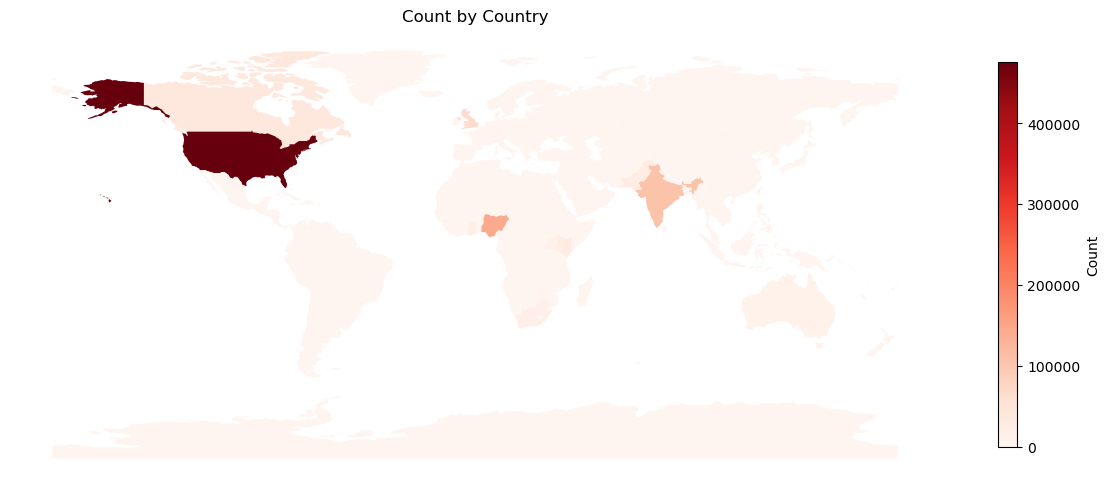

In [64]:
import geopandas as gpd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Load the world map data into a GeoDataFrame
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Join the data with the world map GeoDataFrame
joined_df = world_map.merge(pd_df_1, how='left', left_on='name', right_on='Country')
joined_df['Count'] = joined_df['Count'].fillna(0)

# Create the plot using GeoPandas
ax = joined_df.plot(column='Count', cmap='Reds', legend=True, figsize=(15, 10),
                    legend_kwds={'label': "Count", 'orientation': "vertical", 'shrink': 0.5})

# Set the plot title and remove the axes
ax.set_title('Count by Country')
ax.set_axis_off()

# Display the plot
plt.show()


In [65]:
joined_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,Count
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,0.0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,0.0
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,0.0
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,40131.0
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,476195.0


In [67]:
df_raw = df_raw.withColumn("date", F.to_date("created_at_timestamp"))

In [68]:
df_raw_chatgpt = df_raw.filter('text like "%chatgpt%"').select(['country', 'user_name', 'followers_count', 'date'])

In [69]:
df_raw_chatgpt.count()

24

In [70]:
df_raw_studentlife = df_raw.filter('text like "%student life%" or text like "%studentlife%"').select(['country', 'user_name', 'followers_count', 'date'])

In [71]:
df_raw_studentlife.count()

147

In [98]:
df_raw_new_policy = df_raw.filter('text like "%new policy%"').select(['country', 'user_name', 'followers_count', 'date', 'tweet_text'])

In [99]:
df_raw_new_policy.count()

2379

In [90]:
df_raw_policy = df_raw.filter('text like "%policy%"').select(['country', 'user_name', 'followers_count', 'date', 'tweet_text'])

In [91]:
df_raw_policy.count()

7332

In [94]:
pd_df_raw_policy = df_raw_policy.limit(5).toPandas()

In [96]:
pd.set_option('display.max_colwidth', 1000)

In [97]:
pd_df_raw_policy.head()

,country,user_name,followers_count,date,tweet_text
0,None,Cathy Bissun ✝️,86,2022-09-01,western students sue university for covid-19 booster policy https://t.co/b2jtqzfzdv via @wsonlinenews
1,United States,Meg Gruber,955,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!
2,United States,MiaGator23,48,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!
3,None,Tarun Sharma,22,2022-11-25,"according to our new education policy, it is the demand of time to implement the computer education in schools to the next level in the state. students are looking towards govt. to initiate in computer science stream. \n#computer_instructor_result\n#bci_sci_फाइनल_रिजल्ट"
4,None,Cait_is_REAL_tired,1882,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!


In [78]:
df_raw_online_education = df_raw.filter('text like "%online education%" or text like "%onlineeducation%"').select(['country', 'user_name', 'followers_count', 'date'])

In [79]:
df_raw_online_education.count()

506

In [80]:
df_raw_brain_break = df_raw.filter('text like "%brain break%" or text like "%brainbreak%"').select(['country', 'user_name', 'followers_count', 'date'])

In [82]:
df_raw_brain_break.count()

14

In [83]:
df_raw_brain_break = df_raw.filter('text like "%blooms%" or text like "%taxonomy%"').select(['country', 'user_name', 'followers_count', 'date'])

In [85]:
df_raw_brain_break.count()

35

In [87]:
df_raw_book_ban = df_raw.filter('text like "%book ban%"').select(['country', 'user_name', 'followers_count', 'date'])

In [89]:
df_raw_book_ban.count()

316

In [125]:
pd_df_required = df_raw_new_policy.toPandas()

In [126]:
pd_df_required.dtypes

country            object
user_name          object
followers_count     int64
date               object
tweet_text         object
dtype: object

In [134]:
pd_df_required.shape

(2379, 5)

In [128]:
pd_df_required.head()

,country,user_name,followers_count,date,tweet_text
0,United States,Meg Gruber,955,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!
1,United States,MiaGator23,48,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!
2,None,Cait_is_REAL_tired,1882,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!
3,None,Sailing Man,74,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!
4,None,Karen,98,2022-11-17,breaking: virginia republican governor glenn youngkin unveils a new policy that will ban the teaching of martin luther king jr. to elementary school students. rt to expose governor youngkin’s whitewashing of history!


In [103]:
@F.udf
def get_month(date_):
    return str(date_)[5:7]

In [129]:
countries = list(pd_df_1['Country'])
countries = countries[:5]

In [130]:
countries

['United States of America', 'Nigeria', 'India', 'United Kingdom', 'Canada']

In [137]:
pd_df_required_new = pd_df_required[pd_df_required['country']=='Nigeria']
pd_df_required_new['date'] = pd.to_datetime(pd_df_required_new['date'])
pd_df_required_new['month'] = pd_df_required_new['date'].dt.to_period('M')
pd_new = pd_df_required_new.groupby('month')['user_name'].agg('count').reset_index().sort_values('month').set_index(keys = 'month', drop = True)
pd_new.head()

/tmp/ipykernel_18844/411805896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_required_new['date'] = pd.to_datetime(pd_df_required_new['date'])
/tmp/ipykernel_18844/411805896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df_required_new['month'] = pd_df_required_new['date'].dt.to_period('M')


,user_name
month,
2022-04,1


In [123]:
pd_new

Series([], Freq: M, Name: user_name, dtype: int64)

In [135]:
for i in countries:
    pd_df_required_new = pd_df_required[pd_df_required['country']==i]
    pd_df_required_new['date'] = pd.to_datetime(pd_df_required_new['date'])
    pd_df_required_new['month'] = pd_df_required['date'].dt.to_period('M')
    pd_new = pd_df_required_new.groupby('month')['user_name'].agg('count').reset_index().sort_values('month').set_index(keys = 'month', drop = True)
    pd_new.head()
    fig = pd_new.plot(kind = 'bar', title = i, color= 'deepskyblue', grid = True)
    fig.set_xlabel('Month')
    fig.set_ylabel('Number of tweets')
    fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
    plt.xticks(rotation = 0)
    plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

### Since the data is not providing any meaningfull insights with the location analysis, performing the timeline analysis

In [139]:
df_raw.limit(5)

user_location,id,created_at,user_name,user_description,verified_status,followers_count,geo_enabled,user_id_str,user_id,tweet_text,text,retweet_count,retweeted_status,geo,stripped,organization,created_at_timestamp,country,date
"Sivasagar, Assam",1546871354871259136,Tue Jul 12 14:57:...,Bitupon Dowarah,Tech Enthusiast a...,false,4,true,1245229306940289025,1245229306940289025,lack of sufficien...,RT @DibyansuL: La...,5,"{null, Tue Jul 12...",null,lack of sufficien...,Others,2022-07-12 14:57:25,null,2022-07-12
Heaven,1592977264966537216,Wed Nov 16 20:25:...,Elgiver 📷,An heir of salvat...,false,1991,false,2712037815,2712037815,how many of you r...,RT @jay_onair: Ho...,195,"{null, Wed Nov 16...",null,how many of you r...,Others,2022-11-16 20:25:50,null,2022-11-16
"lagos, Nigeria",1524781431511203842,Thu May 12 15:59:...,subarrruuu tailor🦋,I like boys who l...,false,311,false,1228368290185142273,1228368290185142273,deborah was stone...,RT @NwankwoEsomch...,437,"{null, Thu May 12...",null,deborah was stone...,Others,2022-05-12 15:59:56,null,2022-05-12
Utah,1590826778897305601,Thu Nov 10 22:00:...,Nebo School District,Nebo School District,false,1468,false,253247356,253247356,foothills element...,Foothills Element...,null,null,null,foothills element...,Schools,2022-11-10 22:00:34,null,2022-11-10
Heaven,1601699017758769152,Sat Dec 10 22:02:...,Justin,I'm a nightmare f...,false,60,false,1578183140098641921,1578183140098641921,"""run, run, run!"" ...","RT @ICHRI: ""Run, ...",39,"{null, Sat Dec 10...",null,run run run! stu...,Others,2022-12-10 22:02:58,null,2022-12-10


In [145]:
df_grouped_date = df_raw.groupBy('date').agg(F.count('id').alias('count_of_tweets'))

In [146]:
pd_df_grouped = df_grouped_date.toPandas()

In [147]:
pd_df_grouped.shape

(310, 2)

In [154]:
df_raw = df_raw.withColumn('year_month',F.date_format(F.col("created_at_timestamp"), "yyyy-MM"))

In [155]:
df_raw.select('created_at_timestamp', 'year_month').limit(5)

created_at_timestamp,year_month
2022-12-08 09:02:57,2022-12
2022-11-20 17:45:34,2022-11
2022-04-16 03:44:41,2022-04
2022-04-16 03:48:40,2022-04
2022-08-28 20:42:51,2022-08


In [169]:
df_filtered_text_like_chatgpt = df_raw.filter('text like "%chatgpt%" or text like "%chat gpt%" or text like "%chatGPT%"').select(['country', 'user_name', 'followers_count', 'date', 'year_month'])

In [170]:
df_filtered_text_like_chatgpt.count()

51

In [173]:
# Sustainable Teaching
df_filtered_text_like_sustainable_teaching = df_raw.filter('text like "%sustainable teaching%" or text like "%Sustainable Teaching%" or text like "%Sustainableteaching%" or text like "%Sustainable teaching%"')\
                .select(['country', 'user_name', 'followers_count', 'date', 'year_month'])

In [176]:
df_filtered_text_like_sustainable_teaching

country,user_name,followers_count,date,year_month
null,SchoolRubric,17472,2022-05-05,2022-05


### Looking for trends in edchat

In [196]:
df_filtered_text_like_edchat = df_raw.filter('text like "%edchat%"').select(['country', 'user_name', 'followers_count', 'date', 'year_month', 'user_location'])

In [197]:
df_filtered_text_like_edchat.count()

2270

In [205]:
df_filtered_text_like_edchat_grouped_country = df_filtered_text_like_edchat.groupBy('user_location').agg(F.count('*').alias('count'))

In [206]:
df_filtered_text_like_edchat_grouped_country.limit(5)

user_location,count
Pittsburgh,30
"Los Angeles, CA",4
"Dallas, TX",5
"Cedar Falls, IA",2
Riyadh,1


In [207]:
df_filtered_text_like_edchat_grouped_country.count()

1026

In [225]:
df_filtered_text_like_edchat.count()

2270

In [228]:
df_filtered_text_like_edchat_user = df_filtered_text_like_edchat.groupBy('user_name').agg(F.count('*').alias('count_of_tweets'))

In [229]:
df_filtered_text_like_edchat_user.count()

1361

In [220]:
df_grouped_edchat_year_month = df_filtered_text_like_edchat.groupBy('year_month').agg(F.count('user_name').alias('count_of_users'))

In [221]:
pd_df_grouped_edchat_year_month = df_grouped_edchat_year_month.toPandas()

In [222]:
pd_df_grouped_edchat_year_month.shape

(11, 2)

In [223]:
pd_df_grouped_edchat_year_month.sort_values('year_month', ascending=True, inplace=True)

In [230]:
pd_df_grouped_edchat_year_month.count_of_users.sum()

2270

In [231]:
pd_df_grouped_edchat_year_month.head()

,year_month,count_of_users
0,2022-04,397
9,2022-05,216
1,2022-06,218
3,2022-07,165
2,2022-08,250


In [234]:
pd_df_grouped_edchat_year_month['percentage'] = (pd_df_grouped_edchat_year_month['count_of_users']/pd_df_grouped_edchat_year_month['count_of_users'].sum())*100

In [238]:
pd_df_grouped_edchat_year_month['percentage'] = pd_df_grouped_edchat_year_month['percentage'].apply(lambda x: round(x, 2))

In [239]:
pd_df_grouped_edchat_year_month.head()

,year_month,count_of_users,percentage
0,2022-04,397,17.49
9,2022-05,216,9.52
1,2022-06,218,9.60
3,2022-07,165,7.27
2,2022-08,250,11.01


/tmp/ipykernel_18844/2275101831.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pd_df_grouped_edchat_year_month['year_month'], rotation=45, fontsize=14, ha='right')


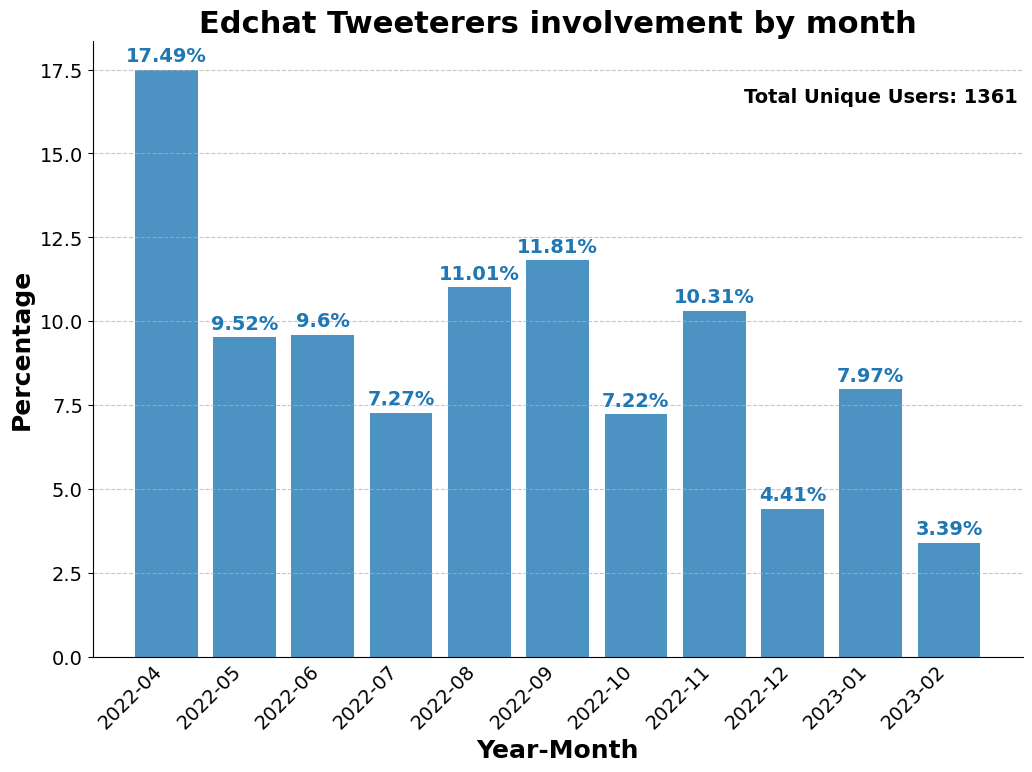

In [270]:
# create the plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(pd_df_grouped_edchat_year_month['year_month'], pd_df_grouped_edchat_year_month['percentage'], color='#1f77b4', alpha=0.8)

# set the title and axis labels
ax.set_title('Edchat Tweeterers involvement by month', fontsize=22, fontweight='bold')
ax.set_xlabel('Year-Month', fontsize=18, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=18, fontweight='bold')

# set the tick labels and rotation angle
ax.set_xticklabels(pd_df_grouped_edchat_year_month['year_month'], rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', length=0)

# add a grid and remove the top and right spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# annotate each bar with the count value
for i, v in enumerate(pd_df_grouped_edchat_year_month['percentage']):
    ax.text(i, v+0.25, str(v) + '%', color='#1f77b4', fontweight='bold', ha='center', fontsize=14)

# add text for total users
ax.annotate('Total Unique Users: 1361', xy=(0.7, 0.90), fontweight = 'bold', fontsize=14, xycoords='axes fraction')

# add a caption with the data source
# ax.text(0.02, -0.15, 'Data source: Twitter API', transform=ax.transAxes, fontsize=12, color='#888888')
# ax.annotate('Total Users')
# adjust the plot layout and save to a file
# plt.tight_layout()
plt.show()

In [272]:
df_raw = df_raw.withColumn('weekday', F.dayofweek(df_raw.date))

In [273]:
pd_df_raw_daf_of_week = df_raw.limit(10).toPandas()

In [277]:
pd_df_raw_daf_of_week[['year_month', 'weekday']].head()

,year_month,weekday
0,2022-07,3
1,2022-11,4
2,2022-05,5
3,2022-11,5
4,2022-12,7


In [278]:
df_grouped_weekday = df_raw.groupBy('weekday').agg(F.count('id').alias('count_of_tweets'))

In [279]:
pd_df_grouped_weekday = df_grouped_weekday.toPandas()

In [291]:
pd_df_grouped_weekday.sort_values('weekday', inplace=True)

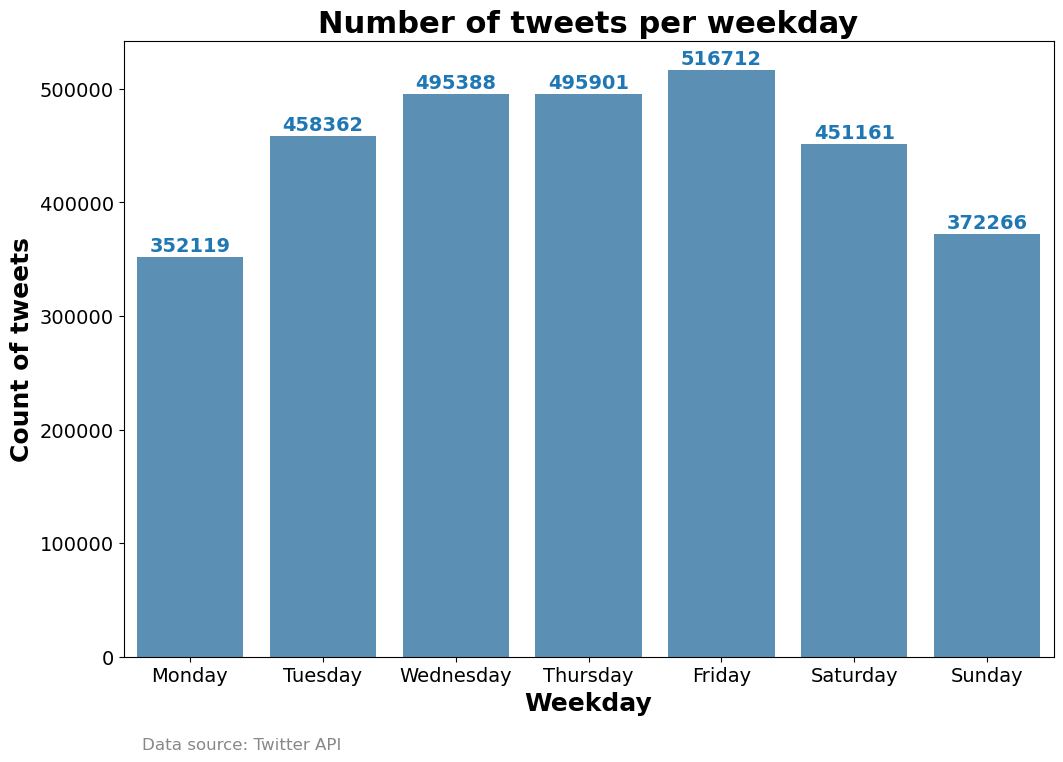

In [292]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='weekday', y='count_of_tweets', data=pd_df_grouped_weekday, ax=ax, color='#1f77b4', alpha=0.8, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# set the title and axis labels
ax.set_title('Number of tweets per weekday', fontsize=22, fontweight='bold')
ax.set_xlabel('Weekday', fontsize=18, fontweight='bold')
ax.set_ylabel('Count of tweets', fontsize=18, fontweight='bold')

# set the tick labels and font size
ax.tick_params(axis='both', labelsize=14)

# add text annotations for each bar
for i, v in enumerate(pd_df_grouped_weekday['count_of_tweets']):
    ax.text(i, v + 5000, str(v), color='#1f77b4', fontweight='bold', ha='center', fontsize=14)

# add a caption with the data source
ax.text(0.02, -0.15, 'Data source: Twitter API', transform=ax.transAxes, fontsize=12, color='#888888')

plt.show()


In [296]:
df_grouped_year_date = df_raw.groupBy('date').agg(F.count('id').alias('count_of_tweets'))

In [311]:
pd_df_grouped_year_date = df_grouped_year_date.toPandas()

In [312]:
pd_df_grouped_year_date.head()

,date,count_of_tweets
0,2022-07-31,7287
1,2022-07-27,10887
2,2022-11-29,10483
3,2022-08-02,9794
4,2022-12-25,2878


In [313]:
pd_df_grouped_year_date.shape

(310, 2)

In [314]:
pd_df_grouped_year_date.sort_values('date', inplace=True)

In [315]:
pd_df_grouped_year_date.head()

,date,count_of_tweets
268,2022-04-05,7885
51,2022-04-06,11242
173,2022-04-07,10601
223,2022-04-08,9595
49,2022-04-09,6862


In [316]:
pd_df_grouped_year_date.tail()

,date,count_of_tweets
151,2023-02-04,6192
111,2023-02-05,5972
122,2023-02-06,6554
197,2023-02-07,9083
9,2023-02-08,4616


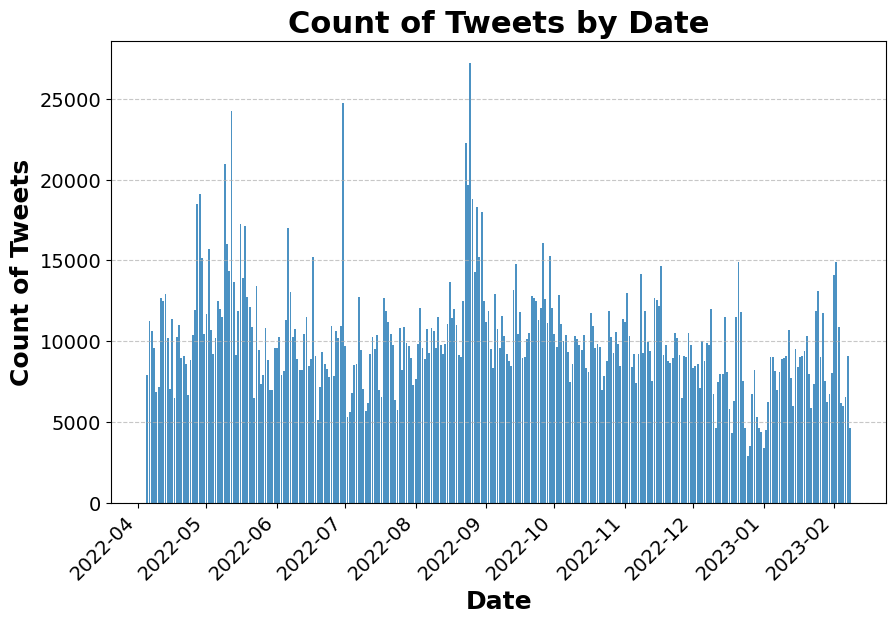

In [318]:
# Convert the 'date' column to datetime
pd_df_grouped_year_date['date'] = pd.to_datetime(pd_df_grouped_year_date['date'])

# Set the figure size and create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(pd_df_grouped_year_date['date'], pd_df_grouped_year_date['count_of_tweets'], color='#1f77b4', alpha=0.8)

# Set the title and axis labels
plt.title('Count of Tweets by Date', fontsize=22, fontweight='bold')
plt.xlabel('Date', fontsize=18, fontweight='bold')
plt.ylabel('Count of Tweets', fontsize=18, fontweight='bold')

# Set the tick labels and rotation angle
plt.xticks(rotation=45, fontsize=14, ha='right')
plt.yticks(fontsize=14)

# Add a grid and remove the top and right spines
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

In [321]:
pd_df_grouped_year_date.sort_values('count_of_tweets', ascending=False).head(10)

,date,count_of_tweets
99,2022-08-25,27225
284,2022-06-30,24759
176,2022-05-12,24217
147,2022-08-23,22245
211,2022-05-09,20954
253,2022-08-24,19682
262,2022-04-28,19123
172,2022-08-26,18801
22,2022-04-27,18454
144,2022-08-28,18319


In [300]:
df_grouped_year_month = df_raw.groupBy('year_month').agg(F.count('id').alias('count_of_tweets'))

In [301]:
pd_df_grouped_year_month = df_grouped_year_month.toPandas()

In [302]:
pd_df_grouped_year_month.shape

(11, 2)

In [322]:
pd_df_grouped_year_month.sort_values('year_month', inplace=True)

/tmp/ipykernel_18844/2268092763.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pd_df_grouped_year_month['year_month'], rotation=45, fontsize=14, ha='right')


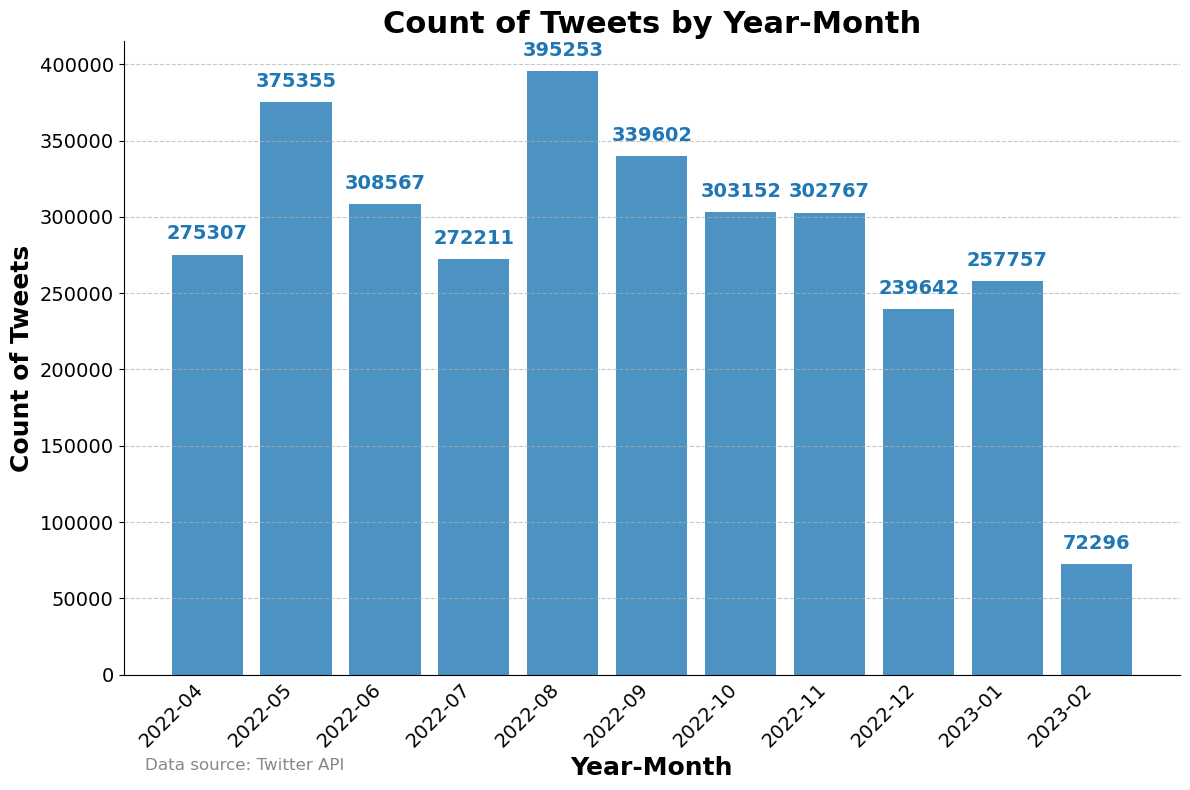

In [323]:
# create the plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(pd_df_grouped_year_month['year_month'], pd_df_grouped_year_month['count_of_tweets'], color='#1f77b4', alpha=0.8)

# set the title and axis labels
ax.set_title('Count of Tweets by Year-Month', fontsize=22, fontweight='bold')
ax.set_xlabel('Year-Month', fontsize=18, fontweight='bold')
ax.set_ylabel('Count of Tweets', fontsize=18, fontweight='bold')

# set the tick labels and rotation angle
ax.set_xticklabels(pd_df_grouped_year_month['year_month'], rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', length=0)

# add a grid and remove the top and right spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# annotate each bar with the count value
for i, v in enumerate(pd_df_grouped_year_month['count_of_tweets']):
    ax.text(i, v+10000, str(v), color='#1f77b4', fontweight='bold', ha='center', fontsize=14)

# add a caption with the data source
ax.text(0.02, -0.15, 'Data source: Twitter API', transform=ax.transAxes, fontsize=12, color='#888888')

# adjust the plot layout and save to a file
plt.tight_layout()
plt.show()

/tmp/ipykernel_18844/2280630061.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pd_df_grouped_year_month['year_month'], rotation=45, fontsize=12)


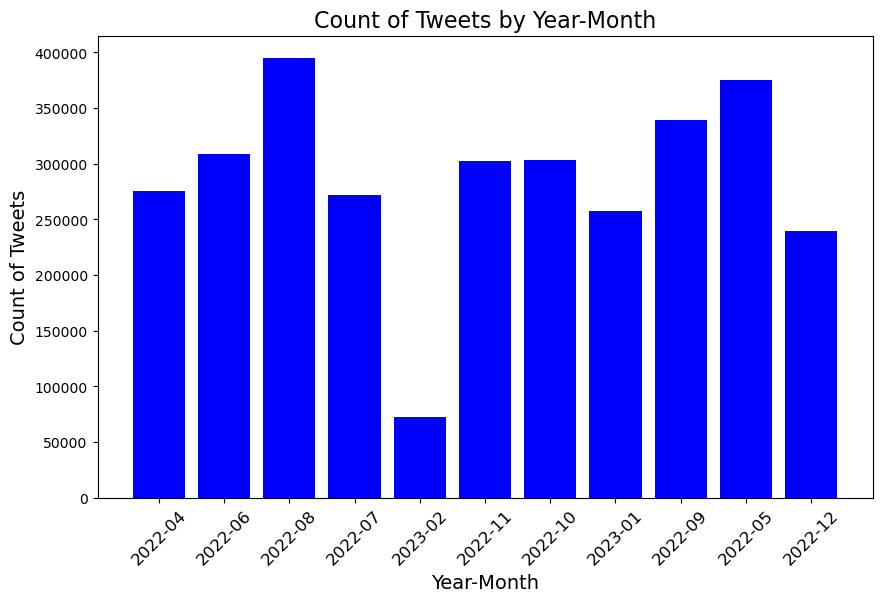

In [161]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(pd_df_grouped_year_month['year_month'], pd_df_grouped_year_month['count_of_tweets'], color='blue')

# set the title and axis labels
ax.set_title('Count of Tweets by Year-Month', fontsize=16)
ax.set_xlabel('Year-Month', fontsize=14)
ax.set_ylabel('Count of Tweets', fontsize=14)

# set the tick labels and rotation angle
ax.set_xticklabels(pd_df_grouped_year_month['year_month'], rotation=45, fontsize=12)

# show the plot
plt.show()